In [4]:
# put the directory path to your LMR repository here
import sys
sys.path.append("/Users/dan/Desktop/LMR_py3/")
#!cd /Users/dan/Desktop/LMR_py3

# prefix for figure filename
#fig_prefix='prior_truth_'

In [5]:
import os
os.chdir('/Users/dan/Desktop/LMR_py3')
import LMR_lite_utils as LMRlite
import LMR_utils
import LMR_config
import numpy as np
import os,sys
from time import time
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature
from cartopy.util import add_cyclic_point
%matplotlib inline
import cartopy.util as cutil
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from mpl_toolkits.axes_grid1 import AxesGrid
import matplotlib.cm as cm



Loading information from datasets.yml
Loading information from grid_def.yml


In [3]:
# use this when revising modules; this reloads
import importlib
importlib.reload(LMRlite)

<module 'LMR_lite_utils' from '/Users/dan/Desktop/LMR_py3/LMR_lite_utils.py'>

In [5]:
# Load and interpolate all of the priors I want to use as truth

lmr_names = ['ccsm4_last_millenium',
             'mpi-esm-p_last_millenium',
             'hadcm3_last_millenium']
model_names = ['CCSM4','MPI-ESM','HadCM3']

# Initialize an array of various interpolated model fields
ad = []

for ii in np.arange(len(lmr_names)):
    dd = {}
    cfile = './configs/config.yml.nullspace.'+lmr_names[ii]+'.1000'
    yaml_file = os.path.join(LMR_config.SRC_DIR,cfile)
    cfg = LMRlite.load_config(yaml_file)
    
    X, Xb_one = LMRlite.load_prior(cfg)
    Xbp = Xb_one - Xb_one.mean(axis=1,keepdims=True)
    
    # check if config is set to regrid the prior
    if cfg.prior.regrid_method:
        print('regridding prior...')
        # this function over-writes X, even if return is given a different name
        [X,Xb_one_new] = LMRlite.prior_regrid(cfg,X,Xb_one,verbose=False)
    else:
        X.trunc_state_info = X.full_state_info
    
    Xb_one = Xb_one_new
    Xbp = Xb_one - Xb_one.mean(axis=1,keepdims=True)
    grid = LMRlite.Grid(X)    
    
    dd['X']        = X
    dd['Xbp']      = Xbp
    dd['name']     = model_names[ii]
    dd['lmr_name'] = lmr_names[ii]
    dd['grid']     = grid

    print(ii)
    print(dd['name'])

    ad.append(dd)
        


Checking configuration ... 
OK!
Reading file:  /Users/dan/Desktop/LMR_py3/data/model/ccsm4_last_millenium/tas_sfc_Amon_CCSM4_past1000_085001-185012.nc
(12012, 192, 288)
indlat= 0  indlon= 1
Anomalies provided as the prior: Removing the temporal mean (for every gridpoint)...
tas : Global(monthly): mean= 8.072375e-07  , std-dev= 1.8899411
Averaging over month sequence: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
tas : Global(time-averaged): mean= 4.4424884352419226e-08  , std-dev= 0.8317386411161235
 
State vector information:
Nx = 55296
state_vect_info= {'tas_sfc_Amon': {'pos': (0, 55295), 'spacecoords': ('lat', 'lon'), 'spacedims': (192, 288), 'vartype': '2D:horizontal'}}
Random selection of 1000 ensemble members
regridding prior...
0 55295
(55296, 1000)
(55296, 2)
(55296, 2)
tas_sfc_Amon  : 2D lat/lon variable, truncating this variable
nlat,nlon: 192 288
=> Full array:      -11.247562408447266 8.779441833496094 0.0002476248215526498 0.8317324770123996
=> Truncated array: -11.1011901257028

In [17]:
# Compute Frobenius differences between covariance matrices without saving them in memory. Uses the fact that ||A|| = \sqrt{tr(A*A)}
# and that the F distance is invariant under multiplication (left and right) by unitary matrices.
# Assumes column vectors of X1 and X2 have (same) dimensions of the state.
# DEA 30 Mar 2020
def cheap_Frob_diff(X1,X2):
    u,s,_ = np.linalg.svd(np.concatenate([X1,X2],1),full_matrices=False)
    _,ns = u.shape
    u1 = u.T.dot(X1)
    u2 = u.T.dot(X2)
    x2d = np.zeros([ns,1])
    for si in np.arange(ns-1):
        x1i = u1.dot(u1[si,:].T)
        x2i = u2.dot(u2[si,:].T)
        x2d[si] = (x2i-x1i).T.dot(x2i-x1i)
        
    fn = np.sqrt(np.sum(x2d))
    return fn
        
    

In [29]:
# Compute Frobenius differences between covariance matrices without saving them in memory. Uses the fact that ||A|| = \sqrt{tr(A*A)}
# and that the F distance is invariant under multiplication (left and right) by unitary matrices.
# Assumes column vectors of X1 and X2 have (same) dimensions of the state.
# DEA 30 Mar 2020
def cheap_Frob_diff_test(X1,X2):
    u,s,_ = np.linalg.svd(np.concatenate([X1,X2],1),full_matrices=True)
    _,ns = u.shape
    u1 = u.T.dot(X1)
    u2 = u.T.dot(X2)
    x2d = np.zeros([ns,1])
    for si in np.arange(ns-1):
        x1i = u1.dot(u1[si,:].T)
        x2i = u2.dot(u2[si,:].T)
        x2d[si] = (x2i-x1i).T.dot(x2i-x1i)
        
    fn = np.sqrt(np.sum(x2d))
    return fn
        
    

In [6]:
# Compute Frobenius differences between covariance matrices without saving them in memory. Uses the fact that ||A|| = \sqrt{tr(A*A)}
# and that the F distance is invariant under multiplication (left and right) by unitary matrices.
# Assumes column vectors of X1 and X2 have (same) dimensions of the state.
# DEA 30 Mar 2020
def cheap_Frob_diff_norm(X1,X2):
    _,c1  = X1.shape
    _,c2  = X2.shape
    u,s,_ = np.linalg.svd(np.concatenate([X1,X2],1),full_matrices=False)
    _,ns  = u.shape
    u1    = u.T.dot(X1/np.sqrt(c1-1.))
    u2    = u.T.dot(X2/np.sqrt(c2-1.))
    x2d = np.zeros([ns,1])
    for si in np.arange(ns-1):
        x1i = u1.dot(u1[si,:].T)
        x2i = u2.dot(u2[si,:].T)
        x2d[si] = (x2i-x1i).T.dot(x2i-x1i)
        
    fn = np.sqrt(np.sum(x2d))
    return fn
        
    

In [23]:
# Is 100 enough for convergence? 
# Now with cheap_frob_diff
def compfrob(mi,ad):

    Xbp = ad[mi]['Xbp']
    Nens = ad[mi]['grid'].nens
    dv = np.empty([1,Nens])

    wXbp = np.sqrt(1/Nens) * Xbp

    for ii in np.arange(3,Nens,100):
        print(mi)
        print(ii)
        Wi = np.sqrt(1/(ii)) * Xbp[:,:ii]
        dv = cheap_Frob_diff(Wi,wXbp)
        
    np.save('/Users/dan/Desktop/Nullspace/pt_out/Frobnorm_' + str(mi), dv)


        
    return dv

In [24]:
# Run in parallel

from joblib import Parallel, delayed
import multiprocessing
num_cores = multiprocessing.cpu_count()
Parallel(n_jobs=3)(delayed(compfrob)(ii,ad) for ii in np.arange(3))

[123.86748695267885, 100.0643028491989, 118.58580417886131]

1000

0
3
53
103
153
203
253
303
353
403
453
503
553
603
653
703
753
803
853
903
953
1
3
53
103
153
203
253
303
353
403
453
503
553
603
653
703
753
803
853
903
953
2
3
53
103
153
203
253
303
353
403
453
503
553
603
653
703
753
803
853
903
953


<function matplotlib.pyplot.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=None)>

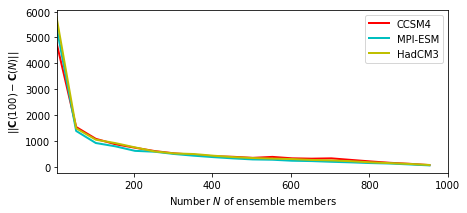

In [37]:
# Is 100 enough for convergence? 
# Now with cheap_frob_diff

plt.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]

plt.figure(figsize=(7,3))
L  = len(np.arange(3,Nens,50))
dv = np.zeros([3,L])
m  = np.zeros(L)

for mi in np.arange(3):
    print(mi)
    Xbp = ad[mi]['Xbp']
    Nens = ad[mi]['grid'].nens
    
    wXbp = np.sqrt(1/Nens) * Xbp

    for ind, ii in enumerate(np.arange(3,Nens,50)):
        print(ii)
        Wi = np.sqrt(1/(ii)) * Xbp[:,:ii]
        dv[mi,ind] = cheap_Frob_diff(Wi,wXbp)
        
#plt.plot(np.arange(Nens)+2,dv.T[:,0],"r",linewidth=2)
#plt.plot(np.arange(Nens)+2,dv.T[:,1],"c",linewidth=2)
#plt.plot(np.arange(Nens)+2,dv.T[:,2],"y",linewidth=2)
#plt.title('Sum of squared differences of EOF weights from 100 ensemble member case')

m = np.arange(3,Nens,50)

plt.plot(m,dv.T[:,0],"r",linewidth=2)
plt.plot(m,dv.T[:,1],"c",linewidth=2)
plt.plot(m,dv.T[:,2],"y",linewidth=2)

plt.xlabel('Number $N$ of ensemble members')
#plt.xticks([2,20,40,60,80,100])
plt.xlim([5,Nens])
#plt.ylabel(r'Residual variance (K$^2$)')
plt.ylabel(r'$\|\|\mathbf{C}(100)-\mathbf{C}(N)\|\|$')
plt.legend([model_names[0],model_names[1],model_names[2]],frameon=True)
plt.tight_layout
# I now think this final picture is just the Frobenius distance!
#plt.savefig('/Users/dan/Desktop/Nullspace_Figs/converges.pdf',bbox_inches='tight')


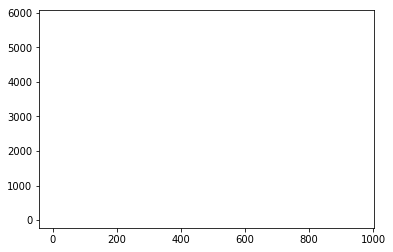

In [28]:
plt.plot(np.arange(Nens)+2,dv.T[:,0],"r",linewidth=2)
plt.plot(np.arange(Nens)+2,dv.T[:,1],"c",linewidth=2)
plt.plot(np.arange(Nens)+2,dv.T[:,2],"y",linewidth=2)

In [31]:
X1 = np.random.randn(3,5)
X2 = np.random.randn(3,5)
print(X1)
print(X2)
A = X1.dot(X1.T)-X2.dot(X2.T)

t1 = np.sqrt(np.trace(A.dot(A)))
t2 = cheap_Frob_diff_test(X1,X2)

print(t1)
print(t2)


[[-1.84199566  0.4122876  -0.54104882  0.25864002  0.57855761]
 [ 1.22629201 -0.52071245 -1.33619826 -1.04651291 -0.39773422]
 [-0.89685591 -1.33882903  1.73135062 -0.07567851  0.51558188]]
[[-0.19877626  0.34015479 -1.05559448  0.66014254 -0.49635129]
 [ 0.07031069 -0.26855309 -1.07084022  1.18630286 -0.53020725]
 [ 1.81146835 -0.28664504 -0.29210625 -1.85382803 -0.42618124]]
7.531913194877397
7.216410425532569
